# Packages

In [1]:
import torch
from torch.autograd import Variable
from collections import namedtuple
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import os
import sys
import random
import time
from PIL import Image
import glob
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import imageio
#设定随机种子
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#用于训练的均值和方差
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

/Users/yunhuinie/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


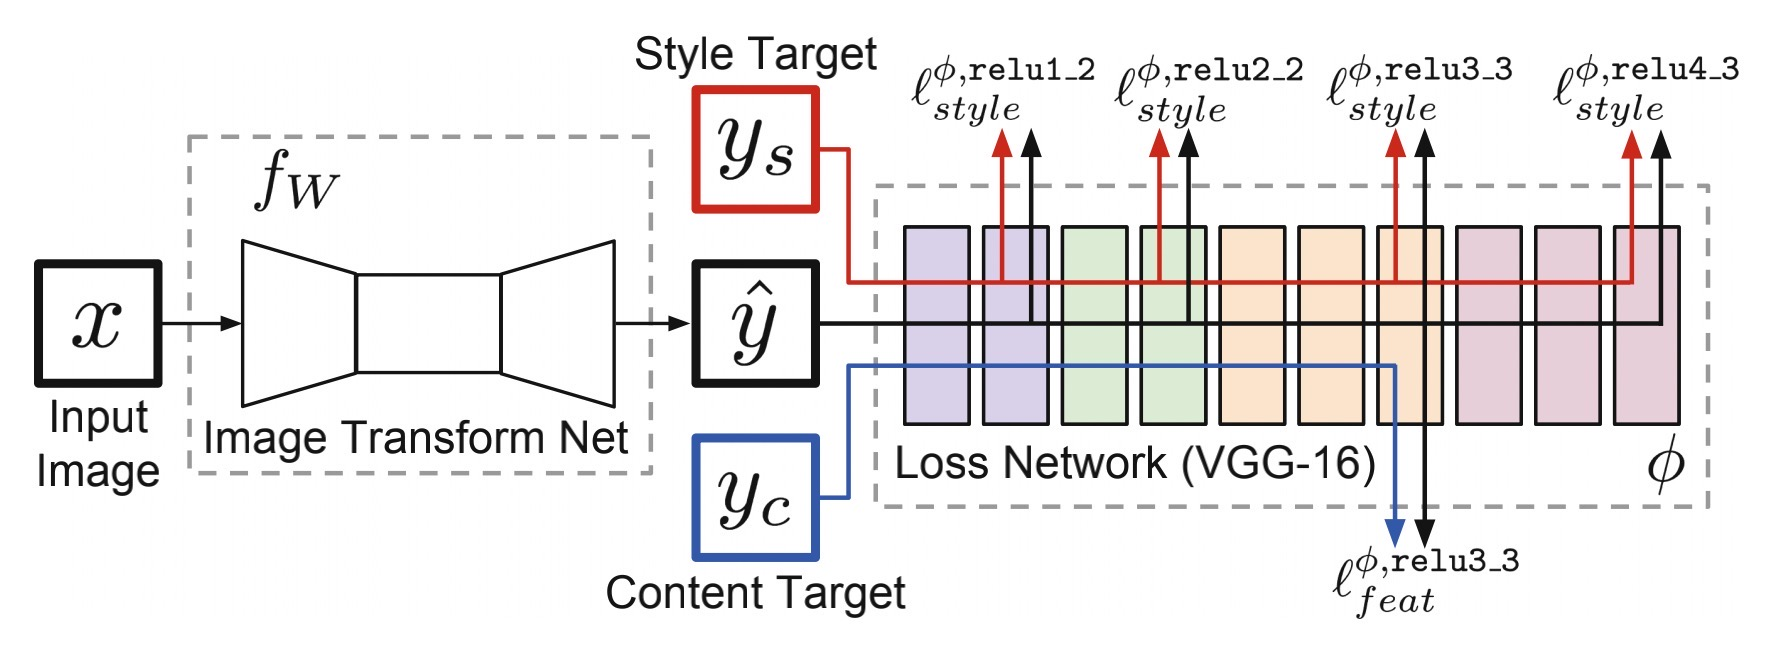

# Transformer

In [2]:
"""转换网络，将输入的图片转换为输出图片：共由前后各三个卷积层和中间五个残差层"""
class TransformerNet(torch.nn.Module):
    def __init__(self):
        super(TransformerNet, self).__init__()
        self.model = nn.Sequential(
            ConvBlock(3, 32, kernel_size=9, stride=1),
            ConvBlock(32, 64, kernel_size=3, stride=2),
            ConvBlock(64, 128, kernel_size=3, stride=2),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ConvBlock(128, 64, kernel_size=3, upsample=True),
            ConvBlock(64, 32, kernel_size=3, upsample=True),
            ConvBlock(32, 3, kernel_size=9, stride=1, normalize=False, relu=False),
        )

    def forward(self, x):
        return self.model(x)

# Residual Layer

In [3]:
"""转换网络中的残差层结构定义"""
class ResidualBlock(torch.nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, stride=1, normalize=True, relu=True),
            ConvBlock(channels, channels, kernel_size=3, stride=1, normalize=True, relu=False),
        )

    def forward(self, x):
        return self.block(x) + x

# Convolution Layer

In [4]:
class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, upsample=False, normalize=True, relu=True):
        super(ConvBlock, self).__init__()
        self.upsample = upsample
        self.block = nn.Sequential(
            nn.ReflectionPad2d(kernel_size // 2), nn.Conv2d(in_channels, out_channels, kernel_size, stride)
        )
        self.norm = nn.InstanceNorm2d(out_channels, affine=True) if normalize else None
        self.relu = relu

    def forward(self, x):
        if self.upsample:
            x = F.interpolate(x, scale_factor=2)
        x = self.block(x)
        if self.norm is not None:
            x = self.norm(x)
        if self.relu:
            x = F.relu(x)
        return x

# VGG16

In [5]:
""" 搭建预训练的VGG16网络框架，用于提取特征信息"""
class VGG16(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super(VGG16, self).__init__()
        vgg_pretrained_features = models.vgg16(pretrained=True).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        
        
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        #按照以往的经验，选择较低层次提取内容特征，能够得到更加精细的内容
        vgg_outputs = namedtuple("VggOutputs", ["relu1_2", "relu2_2", "relu3_3", "relu4_3"]) 
        out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3)
        return out



# Other functions

In [6]:
def gram_matrix(y):
    """格莱姆矩阵，用于计算风格损失"""
    (b, c, h, w) = y.size()
    features = y.view(b, c, w * h)
    features_t = features.transpose(1, 2)  #矩阵转置
    gram = features.bmm(features_t) / (c * h * w) #三维的矩阵在第一维不一致时无法进行乘法，bmm增加了一个batch让剩下两维进行乘法
    return gram


def train_transform(image_size):
    """将训练图片进行转换，resize让它们能够喂入到网络中"""
    transform = transforms.Compose(
        [
            transforms.Resize((int(image_size * 1.15),int(image_size * 1.15))),   #每个size放大1.15倍
            transforms.RandomCrop(image_size),      #对定义的尺寸进行随机翻转
            transforms.ToTensor(),                  #变为张量
            transforms.Normalize(mean, std),        #规一化处理
        ]
    )
    return transform


def style_transform(image_size=None):
    """ 风格图片转换 """
    resize = [transforms.Resize((image_size,image_size))] if image_size else []
    transform = transforms.Compose(resize + [transforms.ToTensor(), transforms.Normalize(mean, std)])
    return transform

def test_transform(image_size=None):
    """ 测试集图片进行转换 """
    resize = [transforms.Resize(image_size)] if image_size else []
    transform = transforms.Compose(resize + [transforms.ToTensor(), transforms.Normalize(mean, std)])
    return transform

def denormalize(tensors):
    """ 利用前面定义的均值和方差进行反归一化处理，作用是还原处理后的图像矩阵 """
    for c in range(3):
        tensors[:, c].mul_(std[c]).add_(mean[c])
    return tensors


def deprocess(image_tensor):
    """ 反归一化处理并重新放大图像张量 """
    image_tensor = denormalize(image_tensor)[0]
    image_tensor *= 255
    image_np = torch.clamp(image_tensor, 0, 255).cpu().numpy().astype(np.uint8)
    image_np = image_np.transpose(1, 2, 0)
    return image_np

In [8]:
""" 定义用于快速风格迁移的训练函数 """
def fast_trainer(style_image,        #设置风格图片
                 style_name,         #设置风格名称
                 dataset_path,       #设置训练集路径
                 image_size=512,     #设置图片大小
                 style_size=448,     #设置风格图片大小
                 batch_size = 2,     #设置一次训练的批量数
                 lr = 1e-3,          #设置学习率
                 epochs = 1,         #设置节点数
                 checkpoint_model = None,   #设置使用的模型
                 checkpoint_interval=200,    #设置模型保存的间隔大小
                 sample_interval=200,       #设置取样的间隔大小
                 lambda_style=10e10,         #设置风格图片的权重大小
                 lambda_content=10e5,):      #设置内容图片的权重大小
    
    os.makedirs(f"./images/outputs/{style_name}-training", exist_ok=True)
    os.makedirs(f"./checkpoints", exist_ok=True)

    """ 为训练集创建文件夹用以保存 """
    train_dataset = datasets.ImageFolder(dataset_path, train_transform(image_size))
    dataloader = DataLoader(train_dataset, batch_size=batch_size)

    """ 初始化前面定义的转换网络和特征提取网络 """
    transformer = TransformerNet().to(device)
    vgg = VGG16(requires_grad=False).to(device)

    """ 加载已有的模型 """
    if checkpoint_model:
        transformer.load_state_dict(torch.load(checkpoint_model))

    """ 定义优化器与损失函数 """
    optimizer = Adam(transformer.parameters(), lr)
    l2_loss = torch.nn.MSELoss().to(device)

    """ 加载风格图像 """
    style = style_transform(style_size)(Image.open(style_image))
    style = style.repeat(batch_size, 1, 1, 1).to(device)

    """ 提取风格特征 """
    features_style = vgg(style)
    gram_style = [gram_matrix(y) for y in features_style]

    """ 取训练集中的八张图片进行可视化以评估模型的训练过程 """
    image_samples = []
    for path in random.sample(glob.glob(f"{dataset_path}/*/*.jpg"), 8):
        image_samples += [style_transform(image_size)(Image.open(path))]
    image_samples = torch.stack(image_samples)

    def save_sample(batches_done):
        """ 评估模型并保存示例图片 """
        transformer.eval()
        with torch.no_grad():
            output = transformer(image_samples.to(device))
        image_grid = denormalize(torch.cat((image_samples.cpu(), output.cpu()), 2))
        save_image(image_grid, f"./images/outputs/{style_name}-training/{batches_done}.jpg", nrow=4)
        transformer.train()
    
    
    train_metrics = {"content": [], "style": [], "total": []}
    for epoch in range(epochs):
        epoch_metrics = {"content": [], "style": [], "total": []}
        for batch_i, (images, _) in enumerate(dataloader):
            optimizer.zero_grad()

            images_original = images.to(device)
            images_transformed = transformer(images_original)

            # 提取图像特征
            features_original = vgg(images_original)
            features_transformed = vgg(images_transformed)

            # 计算内容损失
            content_loss = lambda_content * l2_loss(features_transformed.relu2_2, features_original.relu2_2)

            # 计算风格损失
            style_loss = 0
            for ft_y, gm_s in zip(features_transformed, gram_style):
                gm_y = gram_matrix(ft_y)
                style_loss += l2_loss(gm_y, gm_s[: images.size(0), :, :])
            style_loss *= lambda_style

            total_loss = content_loss + style_loss
            total_loss.backward()
            optimizer.step()

            epoch_metrics["content"] += [content_loss.item()]
            epoch_metrics["style"] += [style_loss.item()]
            epoch_metrics["total"] += [total_loss.item()]
            
            train_metrics["content"] += [content_loss.item()]
            train_metrics["style"] += [style_loss.item()]
            train_metrics["total"] += [total_loss.item()]

            sys.stdout.write( "\r[Epoch %d/%d] [Batch %d/%d] [Content: %.2f (%.2f) Style: %.2f (%.2f) Total: %.2f (%.2f)]"
                % (
                    epoch + 1,
                    epochs,
                    batch_i,
                    len(train_dataset),
                    content_loss.item(),
                    np.mean(epoch_metrics["content"]),
                    style_loss.item(),
                    np.mean(epoch_metrics["style"]),
                    total_loss.item(),
                    np.mean(epoch_metrics["total"]),
                )
            )

            batches_done = epoch * len(dataloader) + batch_i + 1
            if batches_done % sample_interval == 0:
                save_sample(batches_done)

            if checkpoint_interval > 0 and batches_done % checkpoint_interval == 0:
                torch.save(transformer.state_dict(), f"./checkpoints/{style_name}_{batches_done}.pth")


            torch.save(transformer.state_dict(), f"./checkpoints/last_checkpoint_SNC.pth")
            
        print("Training Completed!")

        #将损失图像进行可视化展示
        plt.plot(train_metrics["content"], label = "Content Loss")
        plt.plot(train_metrics["style"], label = "Style Loss")
        plt.plot(train_metrics["total"], label = "Total Loss")
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.legend()
        plt.show()

In [9]:
def test_image(image_path,checkpoint_model,save_path):
    os.makedirs(os.path.join(save_path,"results"), exist_ok=True)

    transform = test_transform()

    # 初始化网络并定义加载模型函数
    transformer = TransformerNet().to(device)
    transformer.load_state_dict(torch.load(checkpoint_model))
    transformer.eval()

    # 初始化输入图像
    image_tensor = Variable(transform(Image.open(image_path))).to(device)
    image_tensor = image_tensor.unsqueeze(0)

    # 利用模型进行风格化处理
    with torch.no_grad():
        stylized_image = denormalize(transformer(image_tensor)).cpu()
    # 保存测试的风格化的图片
    fn = checkpoint_model.split('/')[-1].split('.')[0]
    save_image(stylized_image, os.path.join(save_path,f"results/{fn}-output.jpg"))
    print("Image Saved!")
    #plt.imshow(cv2.cvtColor(imageio.imread(os.path.join(save_path,f"results/{fn}-output.jpg")), cv2.COLOR_BGR2RGB))
    plt.imshow(imageio.imread(os.path.join(save_path,f"results/{fn}-output.jpg")))

In [10]:
#input/gan-getting-started/photo_jpg
dataset_path = 'input/gan-getting-started/photo_jpg/'    #定义训练集路径

[Epoch 1/1] [Batch 3518/7038] [Content: 7737895.00 (8734497.03) Style: 1893261.75 (6311264.04) Total: 9631157.00 (15045761.08)]Training Completed!


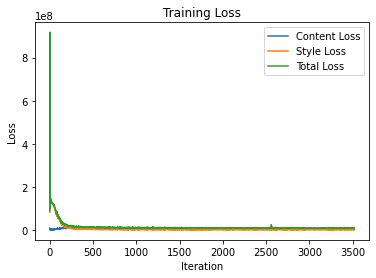

模型训练总时长为: 01:58:39


In [20]:
""" 对模型进行训练 """
#展示训练过程，记录所用时间，保存模型
start_time = time.time()
fast_trainer(style_image='/Users/yunhuinie/Alexnet_Style_Transfer_results/style_input/Van_Gogh_Golden_Wheat_Field.jpg',style_name = 'Van_Gogh_Golden_Wheat_Field'
             ,dataset_path = dataset_path, epochs = 1)

end_time = time.time()
elapsed_time = time.strftime("%H:%M:%S", time.gmtime(end_time - start_time))

print("模型训练总时长为: %s" % elapsed_time)

In [28]:
mylist = os.listdir('./Test_dataset')
root_path = './Test_dataset/'

# random.seed(5)
# CONTENT_IMAGE_PATH = root_path + random.choice(mylist) 
CONTENT_IMAGE_PATH = root_path + '000000026806.jpg'

Image Saved!
模型训练总时长为: 00:00:02


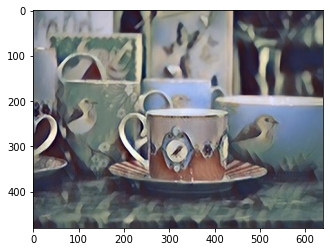

In [29]:
#对训练出的模型利用测试图片进行快速风格迁移处理
start_time = time.time()
test_image(image_path = CONTENT_IMAGE_PATH,
           checkpoint_model = 'checkpoints/Francis_3400.pth',
           save_path = './')

end_time = time.time()
elapsed_time = time.strftime("%H:%M:%S", time.gmtime(end_time - start_time))

print("模型训练总时长为: %s" % elapsed_time)